In [1]:
#!pip install synapseclient

In [2]:
#!pip install synapseutils

In [3]:
#  import synapseclient 
#  import synapseutils 
 
#  syn = synapseclient.Synapse() 
#  syn.login('finamintoastcrunch','1Hjldria!') 
#  files = synapseutils.syncFromSynapse(syn, ' syn2825306 ') 

# Import Libraries

In [4]:
import tensorflow as tf
from tensorflow import keras
from datetime import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from tensorflow.keras.layers import*
import shap
from keras.utils.vis_utils import plot_model
import tensorflow.keras.backend as K
# from keras.layers import Input
# from keras.layers import Dense
# from keras.layers import Conv1D
# from keras.layers import Conv1DTranspose
# from keras.layers import Flatten, Reshape

import os
from glob import glob
from tqdm import tqdm
from tensorflow.keras import losses
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

In [5]:
df = pd.DataFrame

In [6]:
tf.config.list_physical_devices(
    device_type=None
)
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [7]:
tf.executing_eagerly()

True

In [8]:
import warnings
warnings.filterwarnings('ignore')

In [9]:
import matplotlib.pylab as pylab
params = {'legend.fontsize': 'x-large',
          'figure.figsize': (15, 5),
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large'}
pylab.rcParams.update(params)

In [10]:
gpus = tf.config.list_physical_devices('GPU')
if gpus:
  try:
    # Currently, memory growth needs to be the same across GPUs
    for gpu in gpus:
      tf.config.experimental.set_memory_growth(gpu, True)
    logical_gpus = tf.config.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Memory growth must be set before GPUs have been initialized
    print(e)

1 Physical GPUs, 1 Logical GPUs


In [11]:
NUM_PARENTS = 7
NUM_TARGETS = 7
NUM_TIME_STEPS = 3
NUM_REPLICATES = 25 #there are 25 different experiments. so "num replicates" is being used loosely

In [12]:

# matrix_path = "regulator-gene-matrix.csv"
# data_path_syn = r"C:\Users\Fin Amin\Desktop\StemCellResearch\Fin_preProcessed\synData"
# data_path_inter =  r"C:\Users\Fin Amin\Desktop\StemCellResearch\Fin_preProcessed\interpolatedOnly"
# data_path_og_exp1 = r"C:\Users\Fin Amin\Desktop\StemCellResearch\Fin_preProcessed\datasets\exp1"
# data_path_testSet = r"C:\Users\Fin Amin\Desktop\StemCellResearch\testSetFixed"
# data_path_petal = r"C:\Users\Fin Amin\Desktop\StemCellResearch\petal_len.xlsx"

In [13]:
# dirty_RGM = r'Regulations_Control_Altona.csv'
dirty_regulations = r'SignalingNetworkChallenge_TrainingData.csv'

In [14]:
#dirtyRGM = pd.read_csv(dirty_RGM,  index_col = 0, )#on_bad_lines='skip')
dirtyReg = pd.read_csv(dirty_regulations,  index_col = 0,)# on_bad_lines='skip')
dirtyReg = dirtyReg.groupby(['DatasetID'])
dirtyReg.head()

dRegs = []
for i in range(NUM_REPLICATES):
    d = dirtyReg.get_group(i+1)
    key = d.keys()
    key = key[8:15]
    d = d[key].select_dtypes(include=np.number)
    d = d.to_numpy()

    dRegs.append(d)
dRegs = np.array(dRegs, dtype=np.float32)
dRegs.shape
# dirtyReg = dirtyReg.select_dtypes(include=np.number)
# dirtyReg = dirtyReg.to_numpy()
# dirtyReg.shape

(25, 3, 7)

In [15]:

def fix_dataset(dirtyR):
    ds = dirtyR
    ret = np.zeros(shape=(NUM_REPLICATES,NUM_TIME_STEPS, NUM_TARGETS))

    # for i in range(0,NUM_REPLICATES*NUM_TIME_STEPS, 4):
    #     for j in range(0, NUM_REPLICATES):
    #         dataset[j][:,i//NUM_REPLICATES] = dirtyR[:,(i+j)]
    
    ds[ds==-1.0] = np.nan #we do this so the scaling ignores -1s 


    for i in range(NUM_REPLICATES):
        regScaled = MinMaxScaler().fit_transform(ds[i].flatten().reshape((-1,1))) #ignores np.nan
        regScaled = regScaled.reshape((NUM_TARGETS, NUM_TIME_STEPS))
        regScaled = np.nan_to_num(regScaled, nan= -1.0)
        ret[i] = regScaled.T
    return ret

dataset = fix_dataset(dirtyR=dRegs)
dataset.shape

(25, 3, 7)

In [16]:
dataset[0]

array([[7.69989610e-01, 2.68258899e-03, 4.61491853e-01, 4.07580510e-02,
        4.02388349e-02, 5.91034964e-02, 0.00000000e+00],
       [3.81619930e-02, 8.65352340e-05, 1.00000000e+00, 4.84596752e-03,
        4.39685017e-01, 3.60851511e-02, 2.12011077e-02],
       [3.84216011e-02, 3.07199713e-02, 1.71339568e-02, 1.73070235e-04,
        5.40065765e-01, 5.19210938e-04, 4.83212173e-01]])

In [17]:
beanIntensities = dataset[3:]
validation = dataset[0:3]
allData = dataset
print(beanIntensities.shape, validation.shape, allData.shape)

(22, 3, 7) (3, 3, 7) (25, 3, 7)


In [18]:
#the third replicate is trash. we will not use it. 
# df(dataset[3]).head(11) 

In [19]:
# regulator_gene_matrix = np.load("soyBeanRGM.npy")
# regulator_gene_matrix = regulator_gene_matrix.astype('float32')
# regulator_gene_matrix.shape

# RGM and RGM+

In [20]:
regulator_gene_matrix = np.ones((NUM_TARGETS,NUM_TARGETS), dtype='float32')
superParent = np.ones((NUM_TARGETS, NUM_TARGETS), dtype = 'float32')
parentIndex = np.arange(stop=NUM_PARENTS)
parentIndex = tf.convert_to_tensor(parentIndex)
parent_idx = parentIndex.numpy()

In [21]:
parentIndex

<tf.Tensor: shape=(7,), dtype=int32, numpy=array([0, 1, 2, 3, 4, 5, 6])>

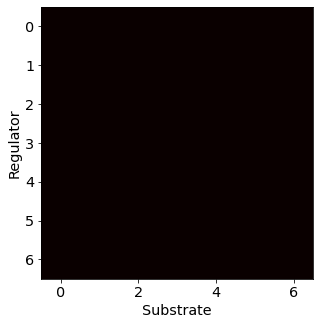

In [22]:
plt.imshow(superParent, cmap='hot');
plt.xlabel("Substrate");
plt.ylabel("Regulator");

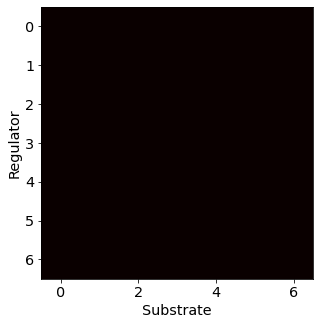

In [23]:
plt.imshow(regulator_gene_matrix, cmap='hot');
plt.xlabel("Substrate");
plt.ylabel("Regulator");

# Custom Loss

In [24]:
# superParent = regulator_gene_matrix.copy() #init the super parent with the ordinary RGM, and do forward passes with super parent
# #print(superParent.shape)

# ones = np.ones((NUM_TARGETS))
# parentIndex = []
# not_parentIndex = []
# for i in range(len(regulator_gene_matrix)):
#     if (np.isin(regulator_gene_matrix[i], [1])).any():
#         #print(i)
#         superParent[i] = ones 
#         parentIndex.append(i)
#     else:
#         not_parentIndex.append(i)

# parentIndex = np.array(parentIndex)
# parentIndex = tf.convert_to_tensor(parentIndex)
# parent_idx = parentIndex.numpy()
# not_parentIndex = np.array(not_parentIndex)
# not_parentIndex = tf.convert_to_tensor(not_parentIndex)
# print("shape of parent index", parentIndex.shape)

def ignore_noParent_MSE_old(y_true, y_pred): 
    l = tf.keras.losses.MeanSquaredError()
    y_true_pruned = tf.gather(y_true,parentIndex, axis =2) 
    #print(y_true_pruned.shape
    y_pred_pruned = tf.gather(y_pred, parentIndex, axis =2)   
    return l(y_true_pruned, y_pred_pruned)

#this will not work if the entire dataset is -1 (degenerate), or has only one actual value (also degen)
def ignore_noParent_MSE(y_true, y_pred): 
    l = tf.keras.losses.MeanSquaredError()
   # print(y_true.shape) #(None, 44, 372)

    #get the parents and flatten them
    y_true_pruned = tf.gather(y_true, parentIndex, axis = 2) #axis 2 because batch, time, gene
    y_true_pruned = tf.reshape(y_true_pruned, shape=([tf.size(y_true_pruned)] ) )

   # print(y_true_pruned.shape)
   # print("tf size", tf.size(y_true_pruned))

    y_pred_pruned = tf.gather(y_pred, parentIndex, axis = 2) 
    y_pred_pruned = tf.reshape(y_pred_pruned, shape=([tf.size(y_pred_pruned)]) )

    #get the index of the parents which are not -1
    y_true_posID = tf.where(y_true_pruned >= 0) #gets args
    y_true_posID = tf.squeeze(y_true_posID)
    #get the idx of all the -1s 
    y_true_negID = tf.where(y_true_pruned < 0) 
    y_true_negID = tf.squeeze(y_true_negID)

    #get all the -1s in the parents 
    y_true_neg = tf.gather(y_true_pruned, y_true_negID) #get all the -1s in y_true
    y_pred_neg = tf.gather(y_pred_pruned, y_true_negID) #get the corresponding values for y_pred

    #get the indexes where pred should be -1 but is not. get the corresponding index for ytrue
    y_shouldBeNegButIsntID = tf.where(y_pred_neg >= 0)  
    y_shouldBeNegButIsntID = tf.squeeze(y_shouldBeNegButIsntID) #get the idx which should be -1 for prediction but are not
    y_true_wrong = tf.gather(y_true_pruned, y_shouldBeNegButIsntID) #get the same corresponding values from ytrue
    y_shouldBeNegButIsnt = tf.gather(y_pred_pruned, y_shouldBeNegButIsntID) #this has all the wrongly predicted values which should be -1 but are not

    y_true_pos = tf.gather(y_true_pruned, y_true_posID)
    y_pred_pos = tf.gather(y_pred_pruned, y_true_posID)

    if tf.size(y_shouldBeNegButIsnt) == 0: #we can not concatenate if the size is 0. 
        return l(y_true_pos, y_pred_pos)

    if tf.size(y_shouldBeNegButIsnt) == 1: #dim goes away if size = 1. 
        y_shouldBeNegButIsnt = tf.expand_dims(y_shouldBeNegButIsnt, axis = 0) #should all be flattened
        y_true_wrong = tf.expand_dims(y_true_wrong, axis=0)

    #print("y_pred", (y_pred_pos), "y_true", (y_shouldBeNegButIsnt))
    try:
        y_pred_total = tf.concat([y_pred_pos, y_shouldBeNegButIsnt], axis = 0) #concatenate for total mse
        y_true_total = tf.concat([y_true_pos, y_true_wrong], axis = 0)
    except Exception as e:
        print(y_pred_pos.shape, y_shouldBeNegButIsnt.shape, tf.size(y_shouldBeNegButIsnt))
        return l(y_true_pos, y_pred_pos)

    return l(y_true_total, y_pred_total)

In [25]:
parent_idx

array([0, 1, 2, 3, 4, 5, 6])

# Ordinary Auto Encoder

In [26]:
class EncoderLinear(tf.keras.layers.Layer):
    def __init__(self, rgm, input_dim=32, units=32):
        super(EncoderLinear, self).__init__()
        self.rgm = rgm
        
        def init_weights(shape, dtype="float32"):

            w_init = tf.random_normal_initializer()(shape=shape, dtype=dtype) * tf.convert_to_tensor(self.rgm, dtype=dtype)

            return w_init
        

        self.w = tf.Variable(
            initial_value=init_weights(shape=(input_dim, units), dtype="float32"),
            trainable=True,
        )

    def call(self, inputs):
        X = inputs
        return tf.matmul(X, tf.multiply(self.rgm, self.w))
    #tf.matmul(inputs, self.w)

In [27]:
class DecoderLinear(tf.keras.layers.Layer):
    def __init__(self, rgm, input_dim=32, units=32):
        super(DecoderLinear, self).__init__()
        self.rgm = rgm

        def init_weights(shape, dtype="float32"):

            w_init = tf.random_normal_initializer()(shape=shape, dtype=dtype) * tf.transpose(tf.convert_to_tensor(self.rgm, dtype=dtype))

            return w_init
    
        
        self.w = tf.Variable(
            initial_value=init_weights(shape=(input_dim, units), dtype="float32"),
            trainable=True,
        )

    def call(self, inputs):
        X = inputs
        #return tf.matmul(X, tf.multiply((self.rgm), self.w))
        X = tf.matmul(X, tf.multiply(tf.transpose(self.rgm), self.w)) 
        #return tf.matmul(inputs, self.w)
        # v = tf.zeros_like(X)
        # u = tf.ones_like(X)
        # u = tf.math.scalar_mul(-3.0, u)
        
        return X#tf.where(tf.math.less(X, v), u, X) #where X is less than 0, return -1 
        
        

In [28]:
def encoder(parent_child_biological_association, num_hidden_units=21):
    '''
    Encoder structure
    '''
    '''
    The data is time-series. Therefore, CNN to learn the temporal relationship between 
    the intensities for each gene.
    '''
    en_conv = Conv1D(490, 3, activation = "relu")(parent_child_biological_association) # 6*NUM_TARGETS Conv1D(32, 3, activation = "relu")(parent_child_biological_association)
    en_dense = Flatten()(en_conv)
    phenotype = Dense(num_hidden_units)(en_dense)
    return phenotype

def decoder(X, num_protein_gene, time_steps):
    '''
    Decoder structure
    '''
    de_dense = Dense(1024)(X)#Dense(128)(X)
    de_dense = Reshape((1, 1024))(de_dense) #tf.reshape(de_dense, (self.batch_size,1,128))
    de_deconv = Conv1DTranspose(num_protein_gene, time_steps, activation = "relu")(de_dense) #used to be transpose
    #de_deconv = Conv1D(num_protein_gene, time_steps, activation = "relu")(de_dense) 
    # gene_reconstruction = self.decoder_biological_operation(de_deconv)
    return de_deconv

def model(rgm, num_protein_gene, time_steps, num_kinase_regulators, num_hidden_units = 32):
    inp = Input(shape=(time_steps, num_kinase_regulators))
    x = EncoderLinear(rgm, NUM_TARGETS, NUM_TARGETS)(inp)
    enc = encoder(x, num_hidden_units)
    dec = decoder(enc, num_protein_gene, time_steps)
    out = DecoderLinear(rgm, NUM_TARGETS, NUM_TARGETS)(dec)

    _model = tf.keras.Model(inputs=inp, outputs=out)

    return _model

In [29]:
ordinaryAE = model(regulator_gene_matrix, NUM_TARGETS, NUM_TIME_STEPS, NUM_TARGETS)
ordinaryAE.compile(optimizer='adam', loss=ignore_noParent_MSE)

In [30]:
o = ordinaryAE.fit(beanIntensities, beanIntensities, epochs=200, verbose = True, validation_data=(validation, validation))
#print(o.history['loss'][-1]) #the final loss 

Epoch 1/200
1/1 [==============================] - 15s 15s/step - loss: 0.1460 - val_loss: 0.1179
Epoch 2/200
1/1 [==============================] - 0s 34ms/step - loss: 0.1435 - val_loss: 0.1175
Epoch 3/200
1/1 [==============================] - 0s 33ms/step - loss: 0.1405 - val_loss: 0.1170
Epoch 4/200
1/1 [==============================] - 0s 29ms/step - loss: 0.1525 - val_loss: 0.1164
Epoch 5/200
1/1 [==============================] - 0s 33ms/step - loss: 0.1483 - val_loss: 0.1155
Epoch 6/200
1/1 [==============================] - 0s 35ms/step - loss: 0.1480 - val_loss: 0.1143
Epoch 7/200
1/1 [==============================] - 0s 30ms/step - loss: 0.1451 - val_loss: 0.1128
Epoch 8/200
1/1 [==============================] - 0s 30ms/step - loss: 0.1451 - val_loss: 0.1108
Epoch 9/200
1/1 [==============================] - 0s 32ms/step - loss: 0.1448 - val_loss: 0.1084
Epoch 10/200
1/1 [==============================] - 0s 34ms/step - loss: 0.1352 - val_loss: 0.1052
Epoch 11/200
1/1 [=

# Super Parent AutoEncoder

In [31]:
class EncoderLinearSuperParent(tf.keras.layers.Layer):
    def __init__(self, rgm, oldrgm, input_dim=32, units=32):
        super(EncoderLinearSuperParent, self).__init__()
        self.rgm = rgm
        self.OGrgm = oldrgm
        
        def init_weights(shape, dtype="float32"):

            w_init = tf.random_normal_initializer()(shape=shape, dtype=dtype) * tf.convert_to_tensor(self.OGrgm, dtype=dtype)

            return w_init
        

        self.w = tf.Variable(
            initial_value=init_weights(shape=(input_dim, units), dtype="float32"),
            trainable=True,
        )

    def call(self, inputs):
        X = inputs
        return tf.matmul(X, tf.multiply(self.rgm, self.w))
    #tf.matmul(inputs, self.w)

class DecoderLinearSuperParent(tf.keras.layers.Layer):
    def __init__(self, rgm, oldrgm, input_dim=32, units=32):
        super(DecoderLinearSuperParent, self).__init__()
        self.rgm = rgm
        self.OGrgm = oldrgm

        def init_weights(shape, dtype="float32"):

            w_init = tf.random_normal_initializer()(shape=shape, dtype=dtype) * tf.transpose(tf.convert_to_tensor(self.rgm, dtype=dtype))

            return w_init
    
        
        self.w = tf.Variable(
            initial_value=init_weights(shape=(input_dim, units), dtype="float32"),
            trainable=True,
        )

    def call(self, inputs):
        X = inputs
        #return tf.matmul(X, tf.multiply((self.rgm), self.w))
        X = tf.matmul(X, tf.multiply(tf.transpose(self.rgm), self.w)) 
        #return tf.matmul(inputs, self.w)
        # v = tf.zeros_like(X)
        # u = tf.ones_like(X)
        # u = tf.math.scalar_mul(-3.0, u)
        
        return X#tf.where(tf.math.less(X, v), u, X) #where X is less than 0, return -1 
        
        
def encoder(parent_child_biological_association, num_hidden_units=21):
    '''
    Encoder structure
    '''
    '''
    The data is time-series. Therefore, CNN to learn the temporal relationship between 
    the intensities for each gene.
    '''
    en_conv = Conv1D(32, 3, activation = "relu")(parent_child_biological_association) # 6*NUM_TARGETS
    en_dense = Flatten()(en_conv)
    phenotype = Dense(num_hidden_units)(en_dense)
    return phenotype

def decoder(X, num_protein_gene, time_steps):
    '''
    Decoder structure
    '''
    de_dense = Dense(128)(X)
    de_dense = Reshape((1, 128))(de_dense) #tf.reshape(de_dense, (self.batch_size,1,128))
    de_deconv = Conv1DTranspose(num_protein_gene, time_steps, activation = "relu")(de_dense) #used to be transpose
    #de_deconv = Conv1D(num_protein_gene, time_steps, activation = "relu")(de_dense) 
    # gene_reconstruction = self.decoder_biological_operation(de_deconv)
    return de_deconv

def modelSuperParent(rgm, oldRGM, num_protein_gene, time_steps, num_kinase_regulators, num_hidden_units = 21): #rgm is set to superparent, oldrgm is original rgm unmodified
    inp = Input(shape=(time_steps, num_kinase_regulators))
    x = EncoderLinearSuperParent(rgm, oldRGM, NUM_TARGETS, NUM_TARGETS)(inp)
    enc = encoder(x, num_hidden_units)
    dec = decoder(enc, num_protein_gene, time_steps)
    out = DecoderLinearSuperParent(rgm, oldRGM, NUM_TARGETS, NUM_TARGETS)(dec)

    _model = tf.keras.Model(inputs=inp, outputs=out)

    return _model

In [32]:
def modelSuperParentSequential(rgm, oldRGM, num_protein_gene, time_steps, num_kinase_regulators, num_hidden_units = 21): #rgm is set to superparent, oldrgm is original rgm unmodified
    m = tf.keras.Sequential()
    inp = Input(shape=(time_steps, num_kinase_regulators))
    x = EncoderLinearSuperParent(rgm, oldRGM, NUM_TARGETS, NUM_TARGETS)(inp)
    enc = encoder(x, num_hidden_units)
    dec = decoder(enc, num_protein_gene, time_steps)
    out = DecoderLinearSuperParent(rgm, oldRGM, NUM_TARGETS, NUM_TARGETS)(dec)

    _model = tf.keras.Model(inputs=inp, outputs=out)

    return _model

In [33]:
looseParent = modelSuperParent(superParent, regulator_gene_matrix, NUM_TARGETS, NUM_TIME_STEPS, NUM_TARGETS, 32)
looseParent.compile(optimizer='adam', loss=ignore_noParent_MSE)
o = looseParent.fit(beanIntensities, beanIntensities, epochs=200, verbose = True,  validation_data=(validation, validation))
#print(o.history['loss'][-1]) #the final loss 

Epoch 1/200
1/1 [==============================] - 3s 3s/step - loss: 0.1437 - val_loss: 0.1179
Epoch 2/200
1/1 [==============================] - 0s 33ms/step - loss: 0.1449 - val_loss: 0.1176
Epoch 3/200
1/1 [==============================] - 0s 35ms/step - loss: 0.1409 - val_loss: 0.1172
Epoch 4/200
1/1 [==============================] - 0s 33ms/step - loss: 0.1417 - val_loss: 0.1168
Epoch 5/200
1/1 [==============================] - 0s 35ms/step - loss: 0.1403 - val_loss: 0.1163
Epoch 6/200
1/1 [==============================] - 0s 33ms/step - loss: 0.1395 - val_loss: 0.1158
Epoch 7/200
1/1 [==============================] - 0s 33ms/step - loss: 0.1411 - val_loss: 0.1152
Epoch 8/200
1/1 [==============================] - 0s 33ms/step - loss: 0.1370 - val_loss: 0.1145
Epoch 9/200
1/1 [==============================] - 0s 34ms/step - loss: 0.1391 - val_loss: 0.1138
Epoch 10/200
1/1 [==============================] - 0s 34ms/step - loss: 0.1369 - val_loss: 0.1129
Epoch 11/200
1/1 [===

# DenseNetAutoEncoder

In [34]:
'''
a second copy of the layers which will be modified to be a denseNET auto encoder
'''
#TODO: fix call to map to -1?
class DenseEncoderLinear2(tf.keras.layers.Layer): #TODO: Fix the decoder to -1
    def __init__(self, rgm, oldrgm, input_dim=32, units=32):
        super(DenseEncoderLinear2, self).__init__()
        self.rgm = rgm
        self.oldrgm = oldrgm
        
        def init_weights(shape, dtype="float32"):

            w_init = tf.random_normal_initializer()(shape=shape, dtype=dtype) * tf.convert_to_tensor(self.oldrgm, dtype=dtype)

            return w_init
        

        self.w = tf.Variable(
            initial_value=init_weights(shape=(input_dim, units), dtype="float32"),
            trainable=True,
        )

    def call(self, inputs):
        X = inputs
        return tf.matmul(X, tf.multiply(self.rgm, self.w))
    #tf.matmul(inputs, self.w)

    def get_config(self):
        config = super().get_config()
        config.update({
            "rgm": self.rgm,
            "oldrgm": self.oldrgm,
            'input_dim': 32,
            'units' : 32
        })

class DenseDecoderLinear2(tf.keras.layers.Layer):
    def __init__(self, rgm, oldrgm, input_dim=32, units=32):
        super(DenseDecoderLinear2, self).__init__()
        self.rgm = rgm
        self.oldrgm = oldrgm

        def init_weights(shape, dtype="float32"):

            w_init = tf.random_normal_initializer()(shape=shape, dtype=dtype) * tf.transpose(tf.convert_to_tensor(self.oldrgm, dtype=dtype))

            return w_init

        self.w = tf.Variable(
            initial_value=init_weights(shape=(input_dim, units), dtype="float32"),
            trainable=True,
        )

    def call(self, inputs):
        X = inputs
        #return tf.matmul(X, tf.multiply((self.rgm), self.w))
        return tf.matmul(X, tf.multiply(tf.transpose(self.rgm), self.w)) #used to have a transpose
        #return tf.matmul(inputs, self.w)

    def get_config(self):
        config = super().get_config()
        config.update({
            "rgm": self.rgm,
            "oldrgm": self.oldrgm,
            'input_dim': 32,
            'units' : 32
        })
        

def denseencoder2(parent_child_biological_association, inp, num_hidden_units=21):
    '''
    Encoder structure
    '''
    '''
    The data is time-series. Therefore, CNN to learn the temporal relationship between 
    the intensities for each gene.
    '''
    en_conv = Conv1D(490, 3, activation = "tanh")(parent_child_biological_association) # 6*NUM_TARGETS
    en_dense = Flatten()(en_conv)
    inp = Flatten()(inp)
    #print(en_dense.shape, inp.shape)
    d = Concatenate()([en_dense, inp]) #dense layer
    o_d = Dense(1024, activation = 'tanh')(d) #added a layer
    c = Concatenate()([o_d, d]) #TOTALY NEW LAYER
    en_dense = Dense(128, activation = 'tanh')(c) #TOTALY NEW LAYER
    
    phenotype = Dense(num_hidden_units, activation="tanh")(d)
    return phenotype

def densedecoder2(X, num_protein_gene, time_steps):
    '''
    Decoder structure
    '''
    de_dense = Dense(784, activation = 'tanh')(X)
    de_dense = Dense(512, activation = 'tanh')(de_dense) #TOTALY NEW LAYER
    de_dense = Dense(256, activation = 'tanh')(de_dense) #added a layer
    de_dense = Reshape((1, 256))(de_dense) #tf.reshape(de_dense, (self.batch_size,1,128))
    de_deconv = Conv1DTranspose(num_protein_gene, time_steps, activation = "tanh")(de_dense) #used to be transpose
    #de_deconv = Conv1D(num_protein_gene, time_steps, activation = "relu")(de_dense) 
    # gene_reconstruction = self.decoder_biological_operation(de_deconv)
    return de_deconv

def modelDense2(rgm, oldrgm, num_protein_gene, time_steps, num_kinase_regulators, num_hidden_units = 21):
    inp = Input(shape=(time_steps, num_kinase_regulators))
    x = DenseEncoderLinear2(rgm, oldrgm, NUM_TARGETS, NUM_TARGETS)(inp)
    #x = EncoderLinear2(x)
    enc = denseencoder2(x, inp, num_hidden_units)
    dec = densedecoder2(enc, num_protein_gene, time_steps)
    out = DenseDecoderLinear2(rgm, oldrgm, NUM_TARGETS, NUM_TARGETS)(dec)

    _model = tf.keras.Model(inputs=inp, outputs=out)

    return _model

In [35]:
dense = modelDense2(superParent, regulator_gene_matrix, NUM_TARGETS, NUM_TIME_STEPS, NUM_TARGETS, 32)
dense.compile(optimizer='adam', loss=ignore_noParent_MSE)
dense.fit(beanIntensities, beanIntensities, epochs=200,  verbose=True, validation_data=(validation, validation))

Epoch 1/200
1/1 [==============================] - 4s 4s/step - loss: 0.1437 - val_loss: 0.1130
Epoch 2/200
1/1 [==============================] - 0s 300ms/step - loss: 0.1350 - val_loss: 0.1075
Epoch 3/200
1/1 [==============================] - 1s 541ms/step - loss: 0.1303 - val_loss: 0.1013
Epoch 4/200
1/1 [==============================] - 1s 541ms/step - loss: 0.1211 - val_loss: 0.0953
Epoch 5/200
1/1 [==============================] - 1s 545ms/step - loss: 0.1137 - val_loss: 0.0907
Epoch 6/200
1/1 [==============================] - 1s 550ms/step - loss: 0.1064 - val_loss: 0.0874
Epoch 7/200
1/1 [==============================] - 0s 467ms/step - loss: 0.1059 - val_loss: 0.0849
Epoch 8/200
1/1 [==============================] - 1s 523ms/step - loss: 0.1054 - val_loss: 0.0827
Epoch 9/200
1/1 [==============================] - 0s 121ms/step - loss: 0.1064 - val_loss: 0.0808
Epoch 10/200
1/1 [==============================] - 1s 523ms/step - loss: 0.1002 - val_loss: 0.0792
Epoch 11/200

In [36]:
dense.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 3, 7)]       0           []                               
                                                                                                  
 dense_encoder_linear2 (DenseEn  (None, 3, 7)        49          ['input_3[0][0]']                
 coderLinear2)                                                                                    
                                                                                                  
 conv1d_2 (Conv1D)              (None, 1, 490)       10780       ['dense_encoder_linear2[0][0]']  
                                                                                                  
 flatten_2 (Flatten)            (None, 490)          0           ['conv1d_2[0][0]']         

# Reconstruction

In [37]:
o = dense.predict(validation)
o.shape

1/1 [==============================] - 0s 185ms/step


(3, 3, 7)

In [38]:
r = pd.DataFrame(o[0].reshape(NUM_TIME_STEPS,NUM_TARGETS))
v = pd.DataFrame(validation[0].reshape(NUM_TIME_STEPS,NUM_TARGETS))

In [39]:
r[parent_idx].head(NUM_TIME_STEPS)

,0,1,2,3,4,5,6
0,0.576596,-0.002022,0.417751,0.232723,0.064618,0.083196,-0.060377
1,0.036716,-0.025285,0.833118,0.039669,0.610879,0.122096,0.093987
2,0.025900,0.020560,0.082863,0.008212,0.561875,0.002690,0.629023


In [40]:
v[parent_idx].head(NUM_TIME_STEPS)

,0,1,2,3,4,5,6
0,0.769990,0.002683,0.461492,0.040758,0.040239,0.059103,0.000000
1,0.038162,0.000087,1.000000,0.004846,0.439685,0.036085,0.021201
2,0.038422,0.030720,0.017134,0.000173,0.540066,0.000519,0.483212


In [44]:
ignore_noParent_MSE(validation, o)

<tf.Tensor: shape=(), dtype=float32, numpy=0.0106005175>

# Latent Space Size Experiment

In [49]:
#to test on entire DS: 
N = 40
hidden = np.arange(2,24, 1) #range(1,32)
lossMatrix = []
for i in tqdm(range(N)):
    
    losses = []
    for value in (hidden):
        dense = modelDense2(superParent, regulator_gene_matrix, NUM_TARGETS, NUM_TIME_STEPS, NUM_TARGETS, value)
        dense.compile(optimizer='adam', loss=ignore_noParent_MSE)
        dense.fit(allData, allData, epochs=40,  verbose=0)
        test_hat = dense(allData) #, verbose = 0)
        loss = ignore_noParent_MSE(allData, test_hat)
        losses.append(loss)
        tf.keras.backend.clear_session()
    lossMatrix.append(losses)
    
lossMatrix = np.array(lossMatrix)
#run 100 times 


#To test on Test set:
# N = 40
# hidden = np.arange(2,24, 1) #range(1,32)
# lossMatrix = []
# for i in tqdm(range(N)):
    
#     losses = []
#     for value in (hidden):
#         dense = modelDense2(superParent, regulator_gene_matrix, NUM_TARGETS, NUM_TIME_STEPS, NUM_TARGETS, value)
#         dense.compile(optimizer='adam', loss=ignore_noParent_MSE)
#         dense.fit(beanIntensities, beanIntensities, epochs=40,  verbose=0)
#         test_hat = dense(validation) #, verbose = 0)
#         loss = ignore_noParent_MSE(validation, test_hat)
#         losses.append(loss)
#         tf.keras.backend.clear_session()
#     lossMatrix.append(losses)
    
# lossMatrix = np.array(lossMatrix)
# #run 100 times 

100%|██████████| 40/40 [36:11<00:00, 54.28s/it]


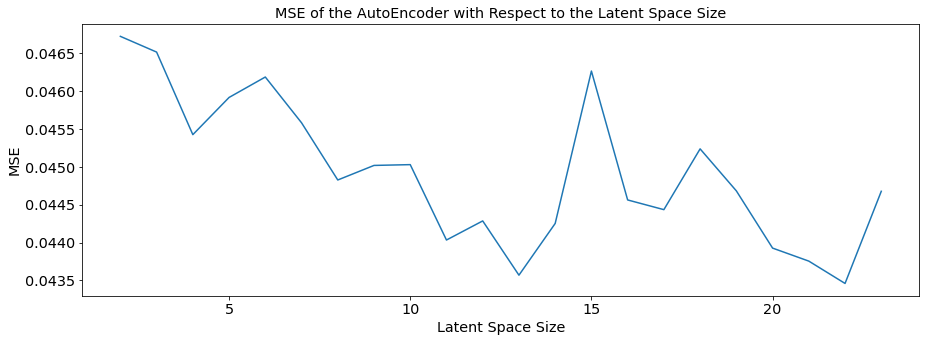

In [50]:
avgMSE = np.average(lossMatrix, axis = 0)
plt.plot(hidden, avgMSE);
plt.xlabel("Latent Space Size");
plt.ylabel("MSE");
plt.title("MSE of the AutoEncoder with Respect to the Latent Space Size");

In [51]:
lm = pd.DataFrame(lossMatrix)
lm.to_csv("lossmatrix4lisa_dream.csv")

In [52]:
temp = pd.read_csv("lossmatrix4lisa_dream.csv").to_numpy()
print(temp.shape)
avgMSE = np.average(lossMatrix, axis=0)

(40, 23)


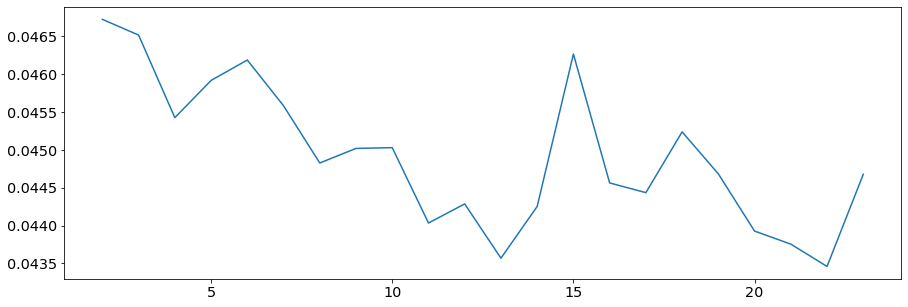

In [53]:
plt.plot(hidden, avgMSE)

# Lazy Kernels

In [41]:
def do_lazy_train(epochs=60, hidden = 32):
    ep = epochs
    hidden = [hidden,] #range(1,32)
    lossMatrix = []
    lazy_weights = []
    dense = modelDense2(superParent, regulator_gene_matrix, NUM_TARGETS, NUM_TIME_STEPS, NUM_TARGETS, num_hidden_units=32)
    dense.compile(optimizer='adam', loss=ignore_noParent_MSE)

    #for i in tqdm(range(ep)):
    for i in range(ep):
        dense.fit(beanIntensities, beanIntensities, validation_data=(validation, validation), epochs=1,  verbose=0)
        lazy_weights.append(dense.get_weights())
        test = dense(validation) #, verbose = 0)
        loss = ignore_noParent_MSE(validation, test)
        lossMatrix.append(loss)
        
    lossMatrix = np.array(lossMatrix)
    lazy_weights = np.array(lazy_weights)

    return lossMatrix, lazy_weights

In [42]:
#https://proceedings.mlr.press/v162/rachwan22a/rachwan22a.pdf Winning the Lottery Ticket Ahead of Time:
def lazyKernelRegime(w, parent_idx=parent_idx):

    firstLayer = []
    for i in range(len(w)):
        firstLayer.append(w[i][0][parent_idx])

    fL = np.array(firstLayer)    
    d0 = np.square(fL[1] - fL[0])
    kernelChange = []
    for i in range(1,len(fL)):
        dt = np.square(fL[i] - fL[0])
        dt_minus1 = np.square(fL[i-1] - fL[0])   
        d = np.abs(dt - dt_minus1)/d0                        #eq 11 from the paper
        kernelChange.append(d)
    
    kernelChange = np.moveaxis(kernelChange, 0, 2)
    # plt.plot(kernelChange[0][0]);
    # plt.title("$|\Delta W|$ vs Epoch")
    # plt.xlabel("Epoch")
    # plt.ylabel("$|\Delta W|$")

    return np.array(  kernelChange)

In [43]:
def compute_distrib(change, t = .05, raw = False): #raw means return the unshaped indicies. 
    stop = []

    for parent in range(len(change)):
        for child in range(len(change[0])):
            try:
                stop.append(np.min(np.argwhere(change[parent][child] < t)))
            except ValueError:
                stop.append(len(change))
                # print(parent, child)
                # plt.plot(change[parent][child])
                # assert(False)
    # print(change.shape)
    # assert(False)
    
    stop = np.array(stop).flatten()
    # print(stop.shape)
    var = np.std(stop)
    # print(var)
    # assert(False)
    mean = np.average(stop)
    top_parents = np.argwhere(stop > mean + 2*var) #get the parents which take more than 2 stds to stop training
    top_parent_child = []
    for tp in top_parents:
        top_parent_child.append(np.unravel_index(tp, shape = (NUM_PARENTS, NUM_TARGETS)))

    if raw == False:
        plt.hist(stop)
        plt.xlabel("Epoch where regulator-target-weight began changing by at most "+ str(t));
        plt.ylabel("Number of parent-child-weights");
        plt.title("Histogram of weight stops");
        print("average stop: ", mean);

    if raw == True:
        return np.array(top_parents)

    return np.array(top_parent_child)

In [44]:
def lazyKernels(N=100):

    candidates = []
    final_w = []
    for i in tqdm(range(N)):
        lm, lazy_weights = do_lazy_train(epochs=80)
        change = lazyKernelRegime(lazy_weights)
        top_pr = np.squeeze(compute_distrib(change, t = 0.05, raw=True))
        candidates.append(top_pr)
        final_w.append(lazy_weights[-1])
    
    final_w = np.array(final_w)
    firstLayer = []
    for i in range(len(final_w)):
        firstLayer.append(np.abs(final_w[i][0][parent_idx]))
    fw = np.array(firstLayer)
    #print(fw.shape)
    fw_avg = np.average(fw, axis = 0)
    #print(fw_avg.shape)
    
    candidates = np.hstack(candidates)
    candidates = candidates.reshape(candidates.size)
    #print(candidates.shape)

    plt.hist(candidates, bins=np.arange(0, NUM_PARENTS*NUM_TARGETS))
    plt.title("Parent-Child Regulator Histogram")
    plt.xlabel("Parent-Child Weight")
    plt.ylabel("Num-Times parent-child relationship trained for top 5% of time")
    return candidates, fw_avg



100%|██████████| 100/100 [59:23<00:00, 35.64s/it] 


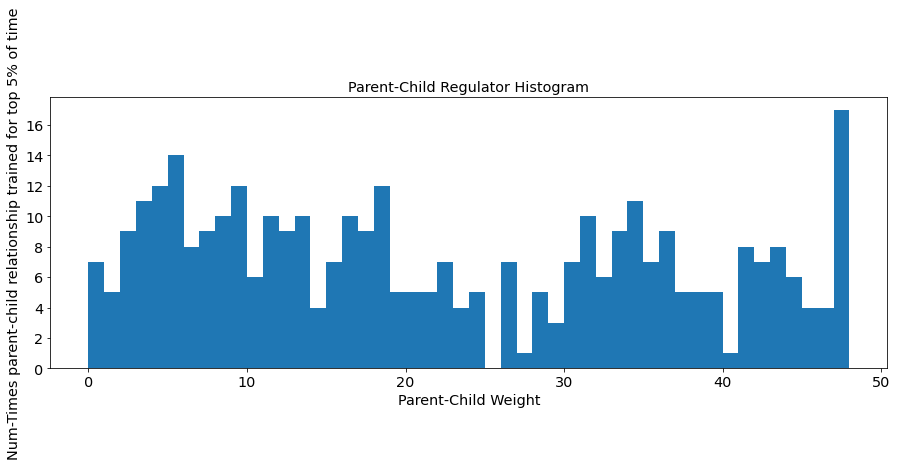

In [45]:
can, mag = lazyKernels()

In [46]:
can.shape

(350,)

In [47]:
pdf, bins = np.histogram(can, np.arange(NUM_PARENTS*NUM_TARGETS))
pdf

array([ 7,  5,  9, 11, 12, 14,  8,  9, 10, 12,  6, 10,  9, 10,  4,  7, 10,
        9, 12,  5,  5,  5,  7,  4,  5,  0,  7,  1,  5,  3,  7, 10,  6,  9,
       11,  7,  9,  5,  5,  5,  1,  8,  7,  8,  6,  4,  4, 17],
      dtype=int64)

In [48]:
mag.shape

(7, 7)

# Magnitudes After Training

In [49]:
NUM_PARENTS*NUM_TARGETS

49

In [50]:
#np.unravel_index(NUM_PARENTS*NUM_TARGETS, shape = (NUM_PARENTS, NUM_TARGETS))

In [51]:
def get_top_reg_targets(can, mag):
    
    pdf, bins = np.histogram(can, np.arange(0, NUM_PARENTS*NUM_TARGETS))
    pdf2d = np.zeros(shape = (NUM_PARENTS,NUM_TARGETS))

    for i in bins:
      idx2d = np.unravel_index(i, shape = (NUM_PARENTS, NUM_TARGETS))
      try:
        pdf2d[idx2d] = pdf[i]
      except IndexError:
        print(i, idx2d, len(pdf), len(bins))
    

    importance = np.multiply(pdf2d, mag)
    return importance

In [52]:
top = get_top_reg_targets(can, mag)

48 (6, 6) 48 49


In [53]:
top.shape

(7, 7)

In [54]:
np.max(top)

0.7652092725038528

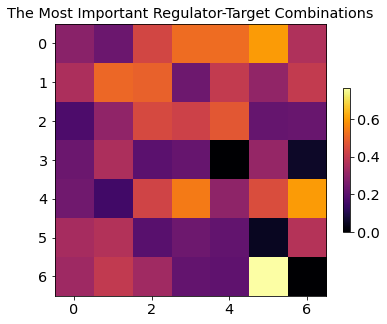

In [55]:
u = plt.imshow(top, cmap = 'inferno', vmin = 0, vmax = np.max(top));
plt.colorbar(u ,fraction=0.0086, pad=0.02);
plt.title("The Most Important Regulator-Target Combinations");

In [56]:
topID = np.array(np.unravel_index(np.argsort(top, axis=None), top.shape))
topID = np.flip(topID, axis=1)
topID[0] = parent_idx[topID[0]]
topID = topID.T
topID

array([[6, 5],
       [0, 5],
       [4, 6],
       [4, 3],
       [0, 3],
       [0, 4],
       [1, 1],
       [1, 2],
       [2, 4],
       [4, 5],
       [2, 2],
       [0, 2],
       [4, 2],
       [2, 3],
       [1, 6],
       [1, 4],
       [6, 1],
       [5, 6],
       [5, 1],
       [0, 6],
       [3, 1],
       [1, 0],
       [5, 0],
       [6, 2],
       [6, 0],
       [3, 5],
       [1, 5],
       [2, 1],
       [4, 4],
       [0, 0],
       [4, 0],
       [5, 3],
       [1, 3],
       [0, 1],
       [3, 0],
       [2, 6],
       [3, 3],
       [2, 5],
       [6, 3],
       [5, 4],
       [6, 4],
       [3, 2],
       [5, 2],
       [2, 0],
       [4, 1],
       [3, 6],
       [5, 5],
       [3, 4],
       [6, 6]], dtype=int64)

In [57]:
topR_T = pd.DataFrame(topID)
topR_T.to_csv("DREAM4_Top_reg_target_decendingOrder_firstColIsRegulator.csv")

In [58]:
best = np.zeros(NUM_PARENTS)
for i in range(NUM_PARENTS):
    best[i] = np.sum(top[i])
best

array([2.94272166, 2.68992035, 2.25494707, 1.37376323, 2.70301308,
       1.76816774, 2.24093457])

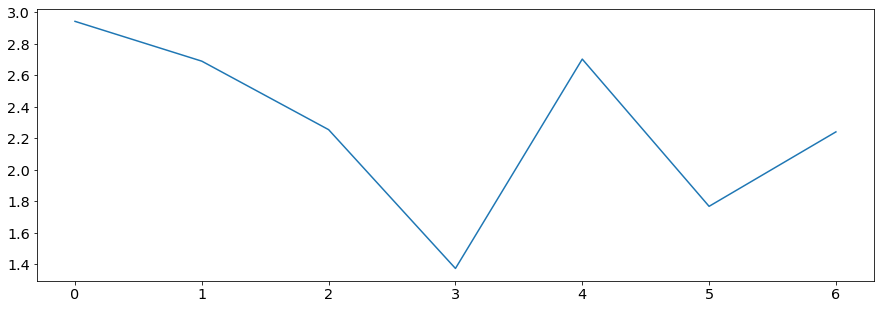

In [59]:
x = np.arange(0,NUM_PARENTS, dtype=int)
plt.plot(x, best); 

In [60]:
idx = np.flip(np.argsort(best))
idx

array([0, 4, 1, 2, 6, 5, 3], dtype=int64)

In [61]:
parent_idx[idx] 

array([0, 4, 1, 2, 6, 5, 3])

In [62]:
np.unique(can).size

48

# Inference on Petal Len

In [ ]:
petal = pd.read_excel(data_path_petal)

In [ ]:
petal_train = petal[petal["Line"] == "WT"]
petal_train = petal_train.drop(columns=['Line', 'ID', "Treatment"])
petal_train.head(12)
petal_train = petal_train.groupby(['Plate']).mean()
petal_train.head()
petal_train = petal_train.to_numpy()
print(petal_train.shape)
scaler1 = StandardScaler()
scaler1.fit(petal_train)
petal_train = scaler1.transform(petal_train)
mm = MinMaxScaler()
mm.fit(petal_train)
petal_train = mm.transform(petal_train)
petal_train

In [ ]:
petal_test = petal[petal["Line"] != "WT"]
petal_test = petal_test.drop(columns=['Line', 'ID', "Treatment"])
petal_test = petal_test.groupby(['Plate']).mean()
petal_test.head()
petal_test = petal_test.to_numpy()
print(petal_test.shape)
petal_test = scaler1.transform(petal_test)
petal_test = mm.transform(petal_test)
petal_test

In [ ]:
experiment1.shape
testCandidate.shape

In [ ]:
densePredictor = modelDense2(superParent, regulator_gene_matrix, NUM_TARGETS, 6, NUM_TARGETS, 22)
densePredictor.compile(optimizer='adam', loss=ignore_noParent_MSE)
densePredictor.fit(beanIntensities, beanIntensities,validation_data=(experiment1, experiment1),  epochs=100,  verbose=1)
test = densePredictor(testCandidate) #, verbose = 0)
loss = ignore_noParent_MSE(testCandidate, test)
print(loss)

In [ ]:
rgm = superParent
time_steps = 6
num_kinase_regulators = NUM_TARGETS
num_hidden_units = 22

inp = Input(shape=(time_steps, num_kinase_regulators))
x = DenseEncoderLinear2(rgm, regulator_gene_matrix, NUM_TARGETS, NUM_TARGETS)(inp)
enc = denseencoder2(x, inp, num_hidden_units)
denseP = tf.keras.Model(inputs=inp, outputs=enc)
#set the weights of the encoder to the weights of auto encoder
dw = densePredictor.get_weights()
enc_w = dw[0:5]
denseP.set_weights(enc_w)
#add a dense layer  because we are ouputing 1 number
l = Dense(32, activation = 'swish', use_bias=True, kernel_regularizer='l1_l2')(denseP.layers[-1].output)
l = Dense(1, activation = 'linear', use_bias = True)(l)
denseP = tf.keras.Model(denseP.inputs, l)
#denseP.summary()

In [ ]:
bp = np.concatenate([experiment1, experiment1, experiment1, experiment1])
bp.shape
#bigexperiment1.shape

In [ ]:
a = petal_train[0]
b = petal_train[1]
c = petal_train[2]
d = petal_train[3]

petal_train1 = np.array([a,a,a,a, b,b,b,b, c,c,c,c, d,d,d,d]) #does this make sense? we are training network to predict .5
petal_train1.shape

In [ ]:
denseP.compile(optimizer='adam', loss=tf.keras.losses.MeanSquaredError())
denseP.fit(experiment1, petal_train, epochs=500, verbose = 1)

In [ ]:
testCandidate.shape

In [ ]:
denseP(experiment1) #experiment1 is part of the training set.

In [ ]:
petal_train

In [ ]:
print(denseP(testCandidate)) #model output

In [ ]:
petal_test #true label

In [ ]:
petal_train

In [ ]:
denseP.evaluate(testCandidate, petal_test) #eval gave 1.3999 before

# Junk

# Load the test set and the synthetic dataset:


In [ ]:
def loadTestSet(test_path):
    testFiles = []
    for np_name in glob(os.path.join(data_path_testSet,'*.np[yz]')):
        k = np.load(os.path.join(data_path_testSet,np_name))
        testFiles.append(k)
#         print(np_name)
#         print(k.shape)
    return np.array(testFiles)

In [ ]:
def read_files(data_path):

    #genes_intensities_data_matrix = pd.read_csv(file_path_intensities, index_col = 0)
    #print(os.listdir(data_path))
    replicate_files = os.listdir(data_path)
    #print('replicate files:',replicate_files)
    replicates = []
    # i = 0
    for file in replicate_files:
        
        try:
            #print('file name:',file)
            #print('value of i:',i)
            genes_intensities_data_matrix = pd.read_csv(os.path.join(data_path , file), index_col = 0, on_bad_lines='skip')
            #print('genes_intensities_data_matrix:',  genes_intensities_data_matrix.head())
            replicates.append(np.array(genes_intensities_data_matrix.values, dtype = float))
            # i+=1
        except PermissionError:
            print("Not a CSV: ", os.path.join(data_path , file))
        
    genes_intensities_data_matrix = genes_intensities_data_matrix.values
    rgm = np.loadtxt(matrix_path)
    rep = np.array(replicates).astype(np.float32)
    
    return rep, rgm.astype(np.float32)

In [ ]:
beanIntensities, regulator_gene_matrix= read_files(data_path_syn)
matrix = regulator_gene_matrix
replicates = beanIntensities

In [ ]:
matrix.shape

In [ ]:
replicates.shape

In [ ]:
plt.imshow(matrix)

In [ ]:
d = np.zeros(shape = (3,6,8))
id = np.unravel_index(3*6*8 - 1, shape = d.shape)
d[id] = 1
plt.imshow(d[2])

In [ ]:
testCandidate[0][ : , parentIndex]

In [ ]:
print(outSyn.shape)
print(testCandidate.shape)
syntheticLoss = ignore_noParent_MSE(np.array([testCandidate[0]]), np.array([outSyn[0]]) )
syntheticLoss

In [ ]:
dd

In [ ]:
plt.plot(change[0][22])
plt.xlabel("epoch")
plt.ylabel("change in weight")

In [ ]:
plt.plot(lossMatrix)
plt.xlabel("epochs")
plt.ylabel("MSE")

In [ ]:
print(change.shape, lossMatrix.shape)

In [ ]:
d = np.diff(change[0][22])
plt.plot(d)
d.shape

In [ ]:
change[0][0].flatten()

In [ ]:
top_pr.shape

In [ ]:
plt.plot(d[0])

In [ ]:

# def compute_tresh(change, stop = 0.05):
#     diffs = []
#     for parent in range(len(change)):
#         for child in range(len(change[0])):
#             diffs.append(np.diff(change[parent][child]))
#     inflection = []


#     try:
#         for d in diffs:
#             print(np.argwhere(np.abs(d) < stop))
#             inflection.append(np.min(np.argwhere(np.abs(d) < stop))) #return where the second derivative is first 0. 

#     except ValueError:
#         print("Stop value ", stop, " is too high, trying stop = ", stop + 0.05)
#         # s = stop + 0.05
#         # return compute_tresh(change, stop = s)
        

#     return np.average(inflection)
        
# d = compute_tresh(change)
# d.shape

In [ ]:
#np.save("mse3.npy", avgMSE) #mse2/3 is with -1 fix

In [ ]:
#https://www.sciencedirect.com/science/article/pii/S0925231220314570?casa_token=lcEJANqO0JwAAAAA:uL3DGUZctPUZz_sPz1K1i2klMtb83TyKnc9CI3_N-uSOaM7VHL8GhM0jCGYfo25NmpDQQ9Cvlw

In [ ]:
rshp = Flatten()(looseParent.layers[-1].output)

modelTemp = tf.keras.Model(inputs=looseParent.input, outputs = [rshp])
modelTemp.summary()
type(modelTemp)
explainer = shap.DeepExplainer(modelTemp, syntheticDataTrain)
#shap.explainers._deep.deep_tf.op_handlers["AddV2"] = shap.explainers._deep.deep_tf.passthrough #this solves the "shap_ADDV2" problem but another one will appear
#shap.explainers._deep.deep_tf.op_handlers["FusedBatchNormV3"] = shap.explainers._deep.deep_tf.passthrough #this solves the next problem which allows you to run the DeepExplainer.

shap_values = explainer.shap_values(testCandidate[0:1])
def f(x):
    return modelTemp.predict(x)

print(f(testCandidate))
explainer = shap.KernelExplainer(f , testCandidate[0:1], link="logit") #svm.predict_proba, X_train, link="logit")
shap_values = explainer.shap_values(testCandidate[0:1], nsamples=100)
def map2layer(x, layer):
    feed_dict = dict(zip([model.layers[0].input], [preprocess_input(x.copy())]))
    return K.get_session().run(model.layers[layer].input, feed_dict)
e = shap.GradientExplainer(
    (model.layers[7].input, model.layers[-1].output),
    map2layer(X, 7),
    local_smoothing=0 # std dev of smoothing noise
)
from keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import preprocess_input
import keras.backend as K
import numpy as np
import json
import shap

# load pre-trained model and choose two images to explain
model = VGG16(weights='imagenet', include_top=True)
X,y = shap.datasets.imagenet50()
to_explain = X[[39,41]]

# load the ImageNet class names
url = "https://s3.amazonaws.com/deep-learning-models/image-models/imagenet_class_index.json"
fname = shap.datasets.cache(url)
with open(fname) as f:
    class_names = json.load(f)

# explain how the input to the 7th layer of the model explains the top two classes
def map2layer(x, layer):
    feed_dict = dict(zip([model.layers[0].input], [preprocess_input(x.copy())]))
    return K.get_session().run(model.layers[layer].input, feed_dict)
e = shap.GradientExplainer(
    (model.layers[7].input, model.layers[-1].output),
    map2layer(X, 7),
    local_smoothing=0 # std dev of smoothing noise
)
shap_values,indexes = e.shap_values(map2layer(to_explain, 7), ranked_outputs=2)

# get the names for the classes
index_names = np.vectorize(lambda x: class_names[str(x)][1])(indexes)

# plot the explanations
shap.image_plot(shap_values, to_explain, index_names)

In [ ]:
type(enc_dec_Synthetic)

In [ ]:
a = [1,2,3]
b = [5,6]
u = tf.concat([a,b], axis = 0)
u

In [ ]:
newConnections = superParent - regulator_gene_matrix

In [ ]:
plt.imshow(newConnections)

In [ ]:
# nC = []
# for i in range(len(newConnections[0])):
#     for j in range(len(newConnections[1])):
#         if newConnections[i][j] > 0:
#             nC.append([i,j])
# nC = np.array(nC)
# nC = pd.DataFrame(nC)
# nC.to_csv("new_connections_in_superParents.csv")

In [ ]:
###Code for testing loss function
# print(outSyn.shape)
# print(testCandidate.shape)
# syntheticLoss = ignore_noParent_MSE(np.array([testCandidate[0]]), np.array([outSyn[0]]) )
# syntheticLoss

# Synthetic Dataset Auto Encoder
Autoencoder has not been trained on synthetic version of experiement 1. We test on the original experiment 1. 

In [ ]:
enc_dec_Synthetic.compile(optimizer='adam', loss=ignore_noParent_MSE)

In [ ]:
# enc_dec_Synthetic.compile(optimizer='adam',loss = keras.losses.SparseCategoricalCrossentropy(from_logits=True))

In [ ]:
syntheticDataTrain = beanIntensities[1:]

In [ ]:
enc_dec_Synthetic.fit(syntheticDataTrain,syntheticDataTrain,epochs=1000)

In [ ]:
test = enc_dec_Synthetic(testCandidate) #, verbose = 0)
loss = ignore_noParent_MSE(testCandidate, test)
loss

In [ ]:
w = enc_dec_Synthetic.get_weights()

In [ ]:
plt.imshow(w[0], cmap = "hot", vmin=0,vmax=0.02)

In [ ]:
#we do not need to use this function for the testset
def getCSVs(data_path_head):
    PATH = data_path_head
    EXT = "*.csv"
    all_csv_files = [file
                     for path, subdir, files in os.walk(PATH)
                     for file in glob(os.path.join(path, EXT))]
    actual = []
    for p in all_csv_files:
        actual.append(pd.read_csv(p, index_col = 0).to_numpy())
    return np.array(actual)
    
experiment1 = getCSVs(data_path_og_exp1)

In [ ]:
testCandidate = test.numpy().astype(np.float)

In [ ]:
testCandidate.dtype

In [ ]:
np.array([beanIntensities[0]]).shape

In [ ]:
testCandidate[0].shape

In [ ]:
np.array([beanIntensities[0]]).shape

In [ ]:
outSyn = enc_dec_Synthetic.predict(testCandidate)

In [ ]:
def mymagn(A, B):
    mse = (np.square(A - B)).mean(axis=None)
    return mse

In [ ]:
print(outSyn.shape)

In [ ]:
syntheticLoss = ignore_noParent_MSE(testCandidate, outSyn )
syntheticLoss

In [ ]:
(outSyn-testCandidate).shape

In [ ]:
#!pip3 install keras-visualizer
#!pip install pydot
#data_path_og_exp1 = data_path_testSet 
# !pip install pydot
# !pip install pydotplus
# !pip install graphviz

In [ ]:
# test = loadTestSet(data_path_testSet)
# testCandidate = test.astype(np.float)


In [ ]:
enc_dec_Synthetic = model(regulator_gene_matrix, NUM_TARGETS, NUM_TIME_STEPS, NUM_TARGETS) #we can just change the time steps to something higher

In [ ]:
enc_dec_Synthetic.summary()

# Interpolated dataset Auto Encoder
Once again, we do not train on any version of exp1

In [ ]:
def read_filesV2(data_path):
    '''
    *Changed*
    currently hardcoded for only one file. 
    change code a bit for reading multiple files.
    '''
    #genes_intensities_data_matrix = pd.read_csv(file_path_intensities, index_col = 0)
    #print(os.listdir(data_path))
    replicate_files = os.listdir(data_path)
    #print('replicate files:',replicate_files)
    replicates = []
    # i = 0
    for file in replicate_files:
        
        #print('file name:',file)
        #print('value of i:',i)
        genes_intensities_data_matrix = pd.read_csv(os.path.join(data_path , file), index_col = 0, on_bad_lines='skip')
        #print('genes_intensities_data_matrix:',  genes_intensities_data_matrix.head())
        replicates.append(genes_intensities_data_matrix.values)
        # i+=1
        
    genes_intensities_data_matrix = genes_intensities_data_matrix.values
    rgm = np.loadtxt(matrix_path)
    
    return np.asarray(replicates), rgm.astype(np.float32)

In [ ]:
interpolated_genes, _ = read_filesV2(data_path_inter)

In [ ]:
interpolated_genes.shape

In [ ]:
pd.DataFrame(interpolated_genes[2]).head(5)

In [ ]:
inter = []
for k in range(len(interpolated_genes)):
    #print(k)
    if k == 2 or k == 3 or k == 4:
        inter.append(np.reshape(interpolated_genes[k], (4,6,NUM_TARGETS)))
    else: 
        inter.append(np.reshape(interpolated_genes[k], (5,6,NUM_TARGETS)))
inter = np.vstack(inter)

In [ ]:
inter.shape

In [ ]:
beanIntensities[1:].shape

In [ ]:
enc_dec_inter = model(regulator_gene_matrix, NUM_TARGETS, 6, NUM_TARGETS) 
enc_dec_inter.compile(optimizer='adam', loss=ignore_noParent_MSE)

In [ ]:
enc_dec_inter.fit(inter, inter,epochs=1000);

In [ ]:
outInter = enc_dec_inter.predict(testCandidate)
interpolationLoss = ignore_noParent_MSE(testCandidate, outInter)

In [ ]:
interpolationLoss #used to be 3.84 on broke ignore

In [ ]:
outInter.shape

In [ ]:
u = enc_dec_inter.history
u

# Comparisons between various outputs:

In [ ]:
u = plt.imshow(np.reshape((np.abs(outSyn)), (24,NUM_TARGETS)), cmap = "hot", vmin=0,vmax=1.0 );

In [ ]:
u = pd.DataFrame(outSyn[0])
u.head(10)

In [ ]:
u = pd.DataFrame(testCandidate[0])
u.head(10)

In [ ]:
plt.figure(figsize=(50, 50))
u = plt.imshow(np.reshape((np.abs(outSyn-outInter)), (24,NUM_TARGETS)), cmap = "hot")#, vmin=0,vmax=1.0 );
plt.title("Difference Between the Outputs of Both Autoencoders", fontsize = 40);
plt.xlabel("Phosphopeptide", fontsize = 30);
plt.ylabel("Times Concatenated", fontsize = 30);
plt.colorbar(u ,fraction=0.0046, pad=0.02);
#plt.savefig("DiffBetweenOut.png")

In [ ]:
plt.figure(figsize=(50, 50))
u = plt.imshow(np.reshape(np.abs(outInter-experiment1), (24,NUM_TARGETS)) , cmap = "hot") #, vmin=0,vmax=1.0 )
plt.title("Difference Between the Input and Output of the Autoencoder Trained on Interpolated Data", fontsize = 40);
plt.xlabel("Phosphopeptide", fontsize = 30)
plt.ylabel("Times Concatenated", fontsize = 30);
plt.colorbar(u ,fraction=0.0046, pad=0.02);
#plt.savefig("InterDiffImage.png")

In [ ]:
plt.figure(figsize=(50, 50))
u = plt.imshow(np.reshape(np.abs(outSyn-experiment1), (24,NUM_TARGETS)), cmap = "hot")#, vmin=0,vmax=1.0 )
plt.title("Difference Between the Input and Output of the Autoencoder Trained on Synthetic Data", fontsize = 40);
plt.xlabel("Phosphopeptide", fontsize = 30);
plt.ylabel("Times Concatenated", fontsize = 30);
plt.colorbar(u ,fraction=0.0046, pad=0.02);
#plt.savefig("SynDiffImage.png");

In [ ]:
parent_idx = parentIndex.numpy()
#print(parent_idx)
oSyn = (np.reshape((outSyn), (24,NUM_TARGETS)).T)[parent_idx]
oSyn = oSyn.T
oSyn.shape

exp1_col = (np.reshape((experiment1), (24,NUM_TARGETS)).T)[parent_idx]
exp1_col = exp1_col.T
print(exp1_col.shape)

u = plt.imshow(np.abs(oSyn - exp1_col), cmap = 'hot') #TODO use TF loss function instead of difference.
ddff = oSyn-exp1_col
plt.colorbar(u)
plt.title("Difference Between the Input and Output of the Autoencoder Trained on Synthetic Data. Only parents.");

In [ ]:
pd.DataFrame(oSyn).head(24)

In [ ]:
pd.DataFrame(exp1_col).head(24)


In [ ]:
pd.DataFrame(ddff).head(24)


In [ ]:
# np.save("interpolated_v2.npy", inter) #the interpolated dataset
# np.save("synthetic_v2.npy", beanIntensities[1:]) # the synthetic dataset
# np.save("synOut_v2.npy", outSyn) #the output of the encoder trained on synthetic data with the input being exp1
# np.save("interOut_v2.npy", outInter) #the output of the encoder trained on interpolated data with the input being exp1